In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)

In [168]:
with open("data/yelp_academic_dataset_review.json", 'r') as f:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    review_json = '[' + ','.join(f.readlines()) + ']'
# read in the json as a DataFrame
reviews = pd.read_json(review_json)

In [169]:
with open("data/yelp_academic_dataset_tip.json", 'r') as f:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    tip_json = '[' + ','.join(f.readlines()) + ']'
# read in the json as a DataFrame
tips = pd.read_json(tip_json)

In [170]:
set(reviews.columns.tolist()).intersection(tips.columns.tolist())

{u'business_id', u'date', u'text', u'type', u'user_id'}

In [171]:
reviews.shape

(230371, 8)

In [172]:
tips.shape


(24072, 6)

In [173]:
# some nan's will exist because of this where reviews columns and tips columns don't match up
reviews_tips = reviews.append(tips)

In [174]:
reviews_tips.shape

(254443, 9)

In [175]:
reviews_tips.columns = [u'restaurant_id', u'review_date', u'tip_likes', u'review_id', u'review_stars', u'review_text', u'review_type', u'user_id', u'review_votes']

In [176]:
with open("data/yelp_academic_dataset_user.json", 'r') as f:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    user_json = '[' + ','.join(f.readlines()) + ']'
# read in the json as a DataFrame
users = pd.read_json(user_json)

In [177]:
users.columns = [u'user_average_stars', u'user_compliments', u'user_elite', u'user_fans', u'user_friends', u'user_name', u'user_review_count', u'user_type', u'user_id', u'user_votes', u'user_yelping_since']

In [178]:
set(reviews_tips.columns.tolist()).intersection(users.columns.tolist())

{u'user_id'}

In [179]:
users.shape

(68650, 11)

In [180]:
users_reviews_tips = pd.merge(reviews_tips, users, on='user_id')

In [181]:
users_reviews_tips.shape

(254443, 19)

In [182]:
with open("data/yelp_academic_dataset_business.json", 'r') as f:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    restaurant_json = '[' + ','.join(f.readlines()) + ']'
# read in the json as a DataFrame
restaurants = pd.read_json(restaurant_json)

In [183]:
restaurants.columns = [u'restaurant_attributes', u'restaurant_id', u'restaurant_categories', u'restaurant_city', u'restaurant_full_address', u'restaurant_hours', u'restaurant_latitude', u'restaurant_longitude', u'restaurant_name', u'restaurant_neighborhoods', u'restaurant_open', u'restaurant_review_count', u'restaurant_stars', u'restaurant_state', u'restaurant_type']

In [184]:
set(users_reviews_tips.columns.tolist()).intersection(restaurants.columns.tolist())

{u'restaurant_id'}

In [185]:
restaurants.shape

(1930, 15)

In [186]:
restaurants_users_reviews_tips = pd.merge(users_reviews_tips, restaurants, on='restaurant_id')

In [187]:
restaurants_users_reviews_tips.shape

(254443, 33)

In [188]:
with open("data/yelp_academic_dataset_checkin.json", 'r') as f:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    checkin_json = '[' + ','.join(f.readlines()) + ']'
# read in the json as a DataFrame
checkins = pd.read_json(checkin_json)

In [189]:
checkins.columns = [u'restaurant_id', u'checkin_info', u'checkin_type']

In [190]:
set(restaurants_users_reviews_tips.columns.tolist()).intersection(checkins.columns.tolist())

{u'restaurant_id'}

In [191]:
checkins.shape

(1630, 3)

In [192]:
full_features = pd.merge(restaurants_users_reviews_tips, checkins, how='left', on='restaurant_id')

In [193]:
full_features.shape

(254443, 35)

In [194]:
id_map = pd.read_csv("data/restaurant_ids_to_yelp_ids.csv")

In [195]:
id_dict = {}
# each Yelp ID may correspond to up to 4 Boston IDs
for i, row in id_map.iterrows():
    # get the Boston ID
    boston_id = row["restaurant_id"]
    
    # get the non-null Yelp IDs
    non_null_mask = ~pd.isnull(row.ix[1:])
    yelp_ids = row[1:][non_null_mask].values
    
    for yelp_id in yelp_ids:
        id_dict[yelp_id] = boston_id

In [196]:
# replace yelp business_id with boston restaurant_id
map_to_boston_ids = lambda yelp_id: id_dict[yelp_id] if yelp_id in id_dict else np.nan
full_features.restaurant_id = full_features.restaurant_id.map(map_to_boston_ids)

In [197]:
full_features.shape

(254443, 35)

In [198]:
# drop restaurants not found in boston data
full_features = full_features[pd.notnull(full_features.restaurant_id)]

In [199]:
full_features.shape

(252767, 35)

In [200]:
training_response = pd.read_csv("data/train_labels.csv", index_col=None)
training_response.columns = ['inspection_id', 'inspection_date', 'restaurant_id', '*', '**', '***']

In [201]:
training_response.shape

(27088, 6)

In [202]:
training_response.inspection_date = pd.to_datetime(pd.Series(training_response.inspection_date))

In [203]:
set(full_features.columns.tolist()).intersection(training_response.columns.tolist())

{'restaurant_id'}

In [204]:
full_features_response = pd.merge(full_features, training_response, on='restaurant_id')

In [205]:
full_features_response.shape

(4071065, 40)

In [206]:
no_future = full_features_response[full_features_response.inspection_date > full_features_response.review_date]

In [207]:
no_future.shape

(1923796, 40)

In [208]:
no_future[pd.notnull(no_future.restaurant_id)].shape

(1923796, 40)

In [40]:
no_future['time_delta'] = (no_future.inspection_date - no_future.review_date).astype('timedelta64[D]')

restaurant_cats = pd.Categorical.from_array(no_future.restaurant_id)
no_future['restaurant_id_number'] = restaurant_cats.codes

# no_future['vote_cool'] = [i[1]['cool'] for i in no_future.review_votes.iteritems()]
# no_future['vote_funny'] = [i[1]['funny'] for i in no_future.review_votes.iteritems()]
# no_future['vote_useful'] = [i[1]['useful'] for i in no_future.review_votes.iteritems()]
# no_future = no_future.drop('review_votes')


In [2]:
import data_grab
train_df, test_df = data_grab.load_dataframes()

In [3]:
# pd.set_option('display.max_rows', 100)
triplex = train_df.sort('inspection_date').set_index(['restaurant_id','inspection_date', 'review_date'])

In [4]:
triplex.head()

tip_likes               review_id  \
restaurant_id inspection_date review_date                                      
1JEbP4oR      2006-10-04      2005-08-04         NaN  XVA3hQr8AOsH-43FQEz6rw   
                              2006-09-01         NaN  UAzMRM2dAv9Q6UO31ObzpA   
              2006-10-19      2006-09-01         NaN  UAzMRM2dAv9Q6UO31ObzpA   
                              2005-08-04         NaN  XVA3hQr8AOsH-43FQEz6rw   
m0oWNg3G      2007-01-02      2005-07-27         NaN  RmEcgZhxFRQfIsrJKnAJ0g   

                                           review_stars  \
restaurant_id inspection_date review_date                 
1JEbP4oR      2006-10-04      2005-08-04              3   
                              2006-09-01              4   
              2006-10-19      2006-09-01              4   
                              2005-08-04              3   
m0oWNg3G      2007-01-02      2005-07-27              4   

                                                                                 review_text  \
restaurant_id inspection_date review_date                                                      
1JEbP4oR      2006-10-04      2005-08-04   Fish here is decent.  They have a nice variety...   
                              2006-09-01   Good delivery restaurant for South Boston.  Va...   
              2006-10-19      2006-09-01   Good delivery restaurant for South Boston.  Va...   
                              2005-08-04   Fish here is decent.  They have a nice variety...   
m0oWNg3G      2007-01-02      2005-07-27   This is the best Borders I've ever seen.  Appa...   

                                          review_type                 user_id  \
restaurant_id inspection_date review_date                                       
1JEbP4oR      2006-10-04      2005-08-04       review  fbAUIhyi2eGAg8cj56VXrA   
                              2006-09-01       review  SA7Eo6JoYfXz8j_d54vYPw   
              2006-10-19      2006-09-01       review  SA7Eo6JoYfXz8j_d54vYPw   
                              2005-08-04       review  fbAUIhyi2eGAg8cj56VXrA   
m0oWNg3G      2007-01-02      2005-07-27       review  7qru-3Wh4xv67dASUqUUng   

                                                                      review_votes  \
restaurant_id inspection_date review_date                                            
1JEbP4oR      2006-10-04      2005-08-04   {u'funny': 0, u'useful': 0, u'cool': 0}   
                              2006-09-01   {u'funny': 0, u'useful': 1, u'cool': 0}   
              2006-10-19      2006-09-01   {u'funny': 0, u'useful': 1, u'cool': 0}   
                              2005-08-04   {u'funny': 0, u'useful': 0, u'cool': 0}   
m0oWNg3G      2007-01-02      2005-07-27   {u'funny': 0, u'useful': 0, u'cool': 0}   

                                           user_average_stars  \
restaurant_id inspection_date review_date                       
1JEbP4oR      2006-10-04      2005-08-04                 3.69   
                              2006-09-01                 3.50   
              2006-10-19      2006-09-01                 3.50   
                              2005-08-04                 3.69   
m0oWNg3G      2007-01-02      2005-07-27                 3.97   

                                          user_compliments    user_elite  \
restaurant_id inspection_date review_date                                  
1JEbP4oR      2006-10-04      2005-08-04                {}  [2006, 2007]   
                              2006-09-01                {}            []   
              2006-10-19      2006-09-01                {}            []   
                              2005-08-04                {}  [2006, 2007]   
m0oWNg3G      2007-01-02      2005-07-27                {}            []   

                                                  ...           \
restaurant_id inspection_date review_date         ...            
1JEbP4oR      2006-10-04      2005-08-04          ...            
                              2006-09

In [93]:
def pull_features(df):
    features = df[['time_delta', 'review_text']]
    features.review_text = features.review_text.apply(lambda x: len(x))
    response = df[['*', '**', '***']].astype(np.float64)
    return features, response

In [94]:
X, y = pull_features(train_df)

In [95]:
y

,*,**,***
0,2,0,0
1,2,0,0
2,2,0,0
3,2,0,0
4,2,0,0
6,5,0,2
7,2,0,3
8,10,1,1
9,10,1,1
10,1,1,3


In [96]:
from sklearn.linear_model import Ridge
ols = Ridge()
model = ols.fit(X,y)

In [97]:
model.score(X,y)

0.0002998757026423382

In [100]:
plt.plot(X['review_text'],y,'.')

AttributeError: 'module' object has no attribute 'scatter'

In [74]:
from sklearn.cross_validation import cross_val_score
np.mean(cross_val_score(Ridge(), X, y, cv=3))

-0.0015265310264372944

In [12]:
submission = pd.read_csv("data/SubmissionFormat.csv", index_col=None)

In [13]:
submission.head()

,id,date,restaurant_id,*,**,***
0,14916,2014-12-17,nkOvZOBW,0,0,0
1,29767,2013-12-30,WwOaAnOB,0,0,0
2,29338,2011-04-08,we39kvOk,0,0,0
3,7219,2013-12-30,dj3d5Xo9,0,0,0
4,20979,2008-03-31,XJ3rBW3R,0,0,0


In [25]:
X_test, y_test = pull_features(test_df)

In [29]:
X_test.head()

,time_delta,restaurant_id_number,review_text
0,1688,181,417
1,2680,181,417
2,596,181,216
3,1588,181,216
4,242,181,1241


In [52]:
predictions = model.predict(X_test)
predictions = np.clip(predictions, 0, np.inf)
# try clipping after averaging scores also

In [53]:
predictions

array([[ 4.5765999 ,  0.39680028,  0.89763117],
       [ 4.69370671,  0.41727775,  0.942159  ],
       [ 4.44578299,  0.37489109,  0.85489531],
       ..., 
       [ 4.31731072,  0.3800991 ,  0.91125927],
       [ 4.42048749,  0.39814075,  0.95049044],
       [ 4.43559804,  0.400783  ,  0.95623597]])

In [33]:
new_submission = data_grab.get_submission().copy()
# new_submission.iloc[:, -3:] = predictions.astype(int)
# new_submission.to_csv('predictions/'+filename)
# train_labels, train_targets = data_grab.get_response()

In [37]:
new_submission.head()

,date,restaurant_id,*,**,***
id,,,,,
14916,2014-12-17,nkOvZOBW,0,0,0
29767,2013-12-30,WwOaAnOB,0,0,0
29338,2011-04-08,we39kvOk,0,0,0
7219,2013-12-30,dj3d5Xo9,0,0,0
20979,2008-03-31,XJ3rBW3R,0,0,0


In [39]:
new_submission.shape

(6772, 5)

In [46]:
X_test.shape

(500885, 3)

In [51]:
test_df[['inspection_date', 'restaurant_id', 'inspection_id', 'restaurant_id_number', '*', '**', '***']].head()

,inspection_date,restaurant_id,inspection_id,restaurant_id_number,*,**,***
0,2010-04-13,6K3lDk3z,18861,181,0,0,0
1,2012-12-30,6K3lDk3z,2409,181,0,0,0
2,2010-04-13,6K3lDk3z,18861,181,0,0,0
3,2012-12-30,6K3lDk3z,2409,181,0,0,0
4,2010-04-13,6K3lDk3z,18861,181,0,0,0


In [ ]:
# predict
# make sure the restaurant_id_number matches to the same restaurant id in both train and test
# is it bad for the restauant id to be counted as a feature in the regression?
# why is test_df bigger than the submission set?
# make sure that all of the submission restaurants are in the training set
# make plot for 1, 2, and 3 star separately for each change in feature and plot features alone too

In [113]:
restaurant_cats.categories.get_indexer(submission.restaurant_id)

array([1438,  946, 1700, ..., 1688, 1376,  704])

In [45]:
train_df.dtypes

restaurant_id                       object
review_date                 datetime64[ns]
tip_likes                          float64
review_id                           object
review_stars                       float64
review_text                         object
review_type                         object
user_id                             object
review_votes                        object
user_average_stars                 float64
user_compliments                    object
user_elite                          object
user_fans                            int64
user_friends                        object
user_name                           object
user_review_count                    int64
user_type                           object
user_votes                          object
user_yelping_since                  object
restaurant_attributes               object
restaurant_categories               object
restaurant_city                     object
restaurant_full_address             object
restaurant_

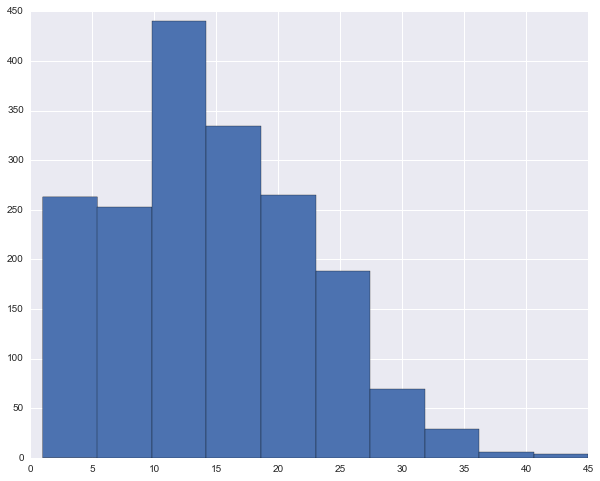

In [65]:
training_response.restaurant_id.value_counts().hist()

In [60]:
training_response.groupby('restaurant_id').sum()

,inspection_id,*,**,***
restaurant_id,,,,
0ZED0WED,409835,106,20,29
0ZED1B3D,213682,37,5,9
0ZED4ED9,113417,40,0,5
0ZED4pED,325997,132,20,40
0ZED543D,108885,35,8,0
0ZED6loD,73468,12,0,3
0ZED7GOD,250998,19,3,9
0ZED8pED,277832,81,2,18
0ZED9B3D,233606,2,0,2


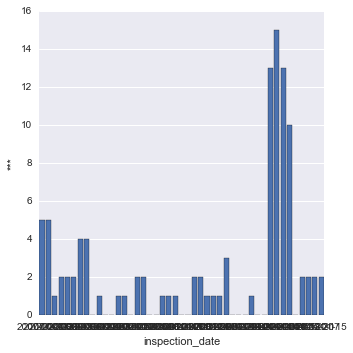

In [68]:
sns.factorplot('inspection_date', '***', data=training_response[training_response.restaurant_id == '1JEbamOR'].sort('inspection_date'), size=5)